## Dependencies

In [6]:
%load_ext tensorboard

In [2]:
import os
import numpy as np
from sklearn.model_selection import KFold
from ipynb.fs.full.Dataset_Construction_Isolated import construct_dataset
import matplotlib.pyplot as plt
import matplotlib.image as plt_img

import tensorflow as tf
from tensorflow.keras import layers, models, datasets
import datetime

from zipfile import ZipFile 

2025-03-02 21:35:38.249407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740947738.264356   13707 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740947738.268739   13707 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-02 21:35:38.284197: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## GPU Check

In [7]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Parameters

In [3]:
name = "ResNet50"
epochs = 10
steps = 50
batch = 40

## Making directory for CNN

In [8]:
try:
    os.mkdir("CNN/" + name)
except:
    pass

try:
    os.mkdir("CNN/" + name + "/Tensorboard_Data")
except:
    pass

## Load constructed dataset

In [4]:
lst = os.listdir() 
if ("mushroom_dataset_x.npy" not in lst) or ("mushroom_dataset_y.npy" not in lst):
    print("Dataset files not found, contructing...")
    dataset_x, dataset_y = construct_dataset()
else:
    print("Dataset files found, loading...")
    dataset_x = np.load("mushroom_dataset_x.npy")
    dataset_y = np.load("mushroom_dataset_y.npy")
    print("Done")

Dataset files found, loading...
Done


## CNN Training

### Create and train Model with n folds

In [5]:
kf = KFold(n_splits=10, shuffle=True)
kf_split = kf.split(dataset_x)
acc_array = []

for i, (train_index, val_index) in enumerate(kf_split):

    pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(227, 227, 3),
    name="resnet50",
    )

    for layer in pretrained_model.layers[:75]:
        layer.trainable = False

    
    cnn = models.Sequential([
    pretrained_model,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
    ])
    
    cnn.compile(optimizer="SGD", loss="binary_crossentropy",  metrics=["accuracy"])
    
    log_dir = "logs/fit/" + name + "-K" + str(i)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, update_freq='batch')
    history = cnn.fit(dataset_x[train_index], 
                      dataset_y[train_index], 
                      validation_data=(dataset_x[val_index], dataset_y[val_index]), 
                      epochs=epochs, 
                      steps_per_epoch=steps, 
                      callbacks=[tensorboard_callback])

    print("K = " + str(i))
    print("Accuracy  {:0.2f} %".format(history.history["accuracy"][-1] * 100))
    acc_array.append(history.history["accuracy"][-1])

I0000 00:00:1740947754.256389   13707 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-03-02 21:35:57.819395: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1113026400 exceeds 10% of free system memory.
2025-03-02 21:35:58.360297: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1113026400 exceeds 10% of free system memory.


Epoch 1/10


I0000 00:00:1740947764.782666   13808 service.cc:148] XLA service 0x7fd8ac14c620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740947764.782707   13808 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-03-02 21:36:05.113171: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740947766.225328   13808 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-02 21:36:08.247805: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8670', 96 bytes spill stores, 96 bytes spill loads

2025-03-02 21:36:08.431212: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4956', 12 bytes

50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 259ms/step - accuracy: 0.6114 - loss: 3.7835 - val_accuracy: 0.6900 - val_loss: 0.6468
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.8073 - loss: 0.4158 - val_accuracy: 0.6900 - val_loss: 0.6831
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.8824 - loss: 0.2740 - val_accuracy: 0.7350 - val_loss: 0.5313
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9320 - loss: 0.1763 - val_accuracy: 0.7550 - val_loss: 0.4786
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.9416 - loss: 0.1383 - val_accuracy: 0.7950 - val_loss: 0.5881
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9653 - loss: 0.0968 - val_accuracy: 0.8550 - val_loss: 0.4531
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9777 - loss: 0.0770 - val_accuracy: 0.9550 - val_loss: 0.1337
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9822 - loss: 0.0563 - val_accuracy: 0.9150 - val_l

2025-03-02 21:37:17.252768: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1113026400 exceeds 10% of free system memory.
2025-03-02 21:37:18.263980: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1113026400 exceeds 10% of free system memory.


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.6000 - loss: 2.4603 - val_accuracy: 0.7100 - val_loss: 0.6083
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.7633 - loss: 0.4760 - val_accuracy: 0.7100 - val_loss: 1.1847
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.8774 - loss: 0.2963 - val_accuracy: 0.7100 - val_loss: 1.3899
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.9353 - loss: 0.1621 - val_accuracy: 0.7200 - val_loss: 0.8575
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9503 - loss: 0.1358 - val_accuracy: 0.7700 - val_loss: 0.8106
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9791 - loss: 0.0539 - val_accuracy: 0.9000 - val_loss: 0.2984
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.9538 - loss: 0.1099 - val_accuracy: 0.9250 - val_loss: 0.1971
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9910 - loss: 0.0273 - val_accuracy: 0.

2025-03-02 21:38:27.784017: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1113026400 exceeds 10% of free system memory.


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 197ms/step - accuracy: 0.6388 - loss: 2.2495 - val_accuracy: 0.7950 - val_loss: 0.5669
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.8240 - loss: 0.3935 - val_accuracy: 0.7950 - val_loss: 0.4550
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.8884 - loss: 0.2544 - val_accuracy: 0.8000 - val_loss: 0.4298
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9565 - loss: 0.1323 - val_accuracy: 0.7500 - val_loss: 0.4780
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9482 - loss: 0.1466 - val_accuracy: 0.9000 - val_loss: 0.2766
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9737 - loss: 0.0687 - val_accuracy: 0.9300 - val_loss: 0.1861
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.9918 - loss: 0.0297 - val_accuracy: 0.9700 - val_loss: 0.1275
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.9960 - loss: 0.0161 - val_accuracy: 0.

### Find best K-group and average

In [9]:
max_acc = max(acc_array)
acc_array.index(max_acc)
avg_acc = sum(acc_array) / len(acc_array)

print("Average accuracy = {:0.2f} %".format(avg_acc * 100))
print("K group with best accuracy = " + str(acc_array.index(max_acc)))
print("Accuracy = {:0.2f} %".format(max_acc * 100))

Average accuracy = 99.03 %
K group with best accuracy = 4
Accuracy = 99.61 %


## Open Tensorboard

In [10]:
%tensorboard --logdir="logs/" --host=127.0.0.1 

## CNN Evaluation

### Load final dataset

In [11]:
if "FinalTrainTestSet" not in os.listdir():
        print("Unzipping final dataset...")
        with ZipFile("FinalTrainTestSet.zip", 'r') as zObject: 
            zObject.extractall(path="FinalTrainTestSet")
        print("Done")
        
print("Loading train_x...")
ftrain_x = np.load("FinalTrainTestSet/train_x.npy")
print("Done")

print("Loading train_y...")
ftrain_y = np.load("FinalTrainTestSet/train_y.npy")
print("Done")

print("Loading test_x...")
ftest_x = np.load("FinalTrainTestSet/test_x.npy")
print("Done")

print("Loading test_y...")
ftest_y = np.load("FinalTrainTestSet/test_y.npy")
print("Done")

Loading train_x...
Done
Loading train_y...
Done
Loading test_x...
Done
Loading test_y...
Done


## Create and train model

In [13]:
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(227, 227, 3),
    name="resnet50",
    )

for layer in pretrained_model.layers[:75]:
    layer.trainable = False

    
cnn = models.Sequential([
    pretrained_model,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
    
cnn.compile(optimizer="SGD", loss="binary_crossentropy",  metrics=["accuracy"])

log_dir = "logs/fit/" + name + "-Final"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, update_freq='epoch')

cnn.fit(ftrain_x, ftrain_y, epochs=epochs, steps_per_epoch=steps, callbacks=[tensorboard_callback])

#cnn.save("CNN/" + name + "/" + name + ".keras")

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.5932 - loss: 3.2363
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.7928 - loss: 0.4147
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.8731 - loss: 0.2828
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9219 - loss: 0.1951
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9469 - loss: 0.1305
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9640 - loss: 0.0947
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9649 - loss: 0.1019
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9800 - loss: 0.0668
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9750 - loss: 0.0525
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9898 - loss: 0.0308


## Open Tensorboard for train time

In [ ]:
%tensorboard --logdir="logs/" --host=127.0.0.1 

## Generate prediction set

In [14]:
pred_y = np.empty([200, 1])
meta = np.empty([1, 227, 227, 3])

for i in range(0, ftest_x.shape[0]):
    meta[0] = ftest_x[i]
    pred_value = cnn.predict(meta, verbose=0)[0][0]
    
    if pred_value > 0.5:
        pred = 1
    else:
        pred = 0
        
    pred_y[i] = pred

## Graph confusion matrix

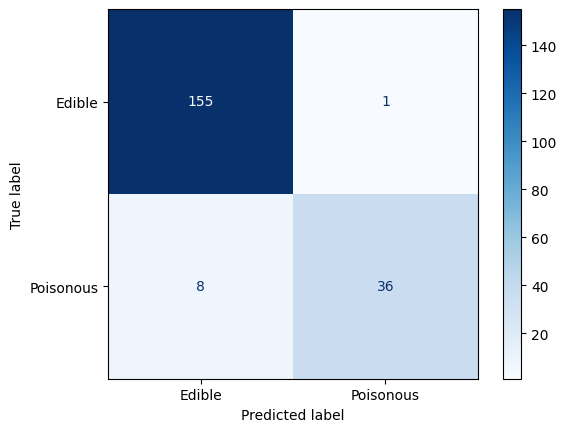

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(ftest_y, pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=["Edible", "Poisonous"])
disp.plot(cmap=plt.cm.Blues).figure_.savefig("CNN/" + name + "/" + name + "_ConfustionMatrix.svg")

## CNN Metrics

In [16]:
tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[1][1]

accuracy = (tp + tn) / (tp + tn + fn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = (precision *  recall) / (precision + recall)
f1 *= 2

print(name + ":")
print("Accuracy  {:0.2f} %".format(accuracy * 100))
print("Precision {:0.2f} %".format(precision * 100))
print("Recall    {:0.2f} %".format(recall * 100))
print("F1        {:0.2f} %".format(f1 * 100))

ResNet50:
Accuracy  95.50 %
Precision 99.36 %
Recall    95.09 %
F1        97.18 %
